In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SalesForecasting").getOrCreate()
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/sales_data.csv" 
sales_data_spark = spark.read.csv(file_path, header=True, inferSchema=True)
sales_data_spark.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| February|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|20

In [0]:
sales_data_pd = sales_data_spark.toPandas()
print(sales_data_pd.head())

       HostItemID    Cost    List  OnHand  MonthsNoSale LastSaleDate  \
0  PMP*14680*2541  381.96  873.72     184            17   2021-04-17   
1  PMP*14680*2541  381.96  873.72     184            17   2021-04-17   
2  PMP*14680*2541  381.96  873.72     184            17   2021-04-17   
3  PMP*14680*2541  381.96  873.72     184            17   2021-04-17   
4  PMP*14680*2541  381.96  873.72     184            17   2021-04-17   

   PriorYearSales  OnOrderQty  BestReorderPoint  SafetyStockLevel  \
0             217          62                74                39   
1             217          62                74                39   
2             217          62                74                39   
3             217          62                74                39   
4             217          62                74                39   

   MonthsWithAtLeastOneSale  Year     Month  Sales  
0                         8  2021   January     39  
1                         8  2021  February   

In [0]:
import pandas as pd
sales_data_pd['LastSaleDate'] = pd.to_datetime(sales_data_pd['LastSaleDate'])
sales_data_pd.set_index('LastSaleDate', inplace=True)
print(sales_data_pd.head())

                  HostItemID    Cost    List  OnHand  MonthsNoSale  \
LastSaleDate                                                         
2021-04-17    PMP*14680*2541  381.96  873.72     184            17   
2021-04-17    PMP*14680*2541  381.96  873.72     184            17   
2021-04-17    PMP*14680*2541  381.96  873.72     184            17   
2021-04-17    PMP*14680*2541  381.96  873.72     184            17   
2021-04-17    PMP*14680*2541  381.96  873.72     184            17   

              PriorYearSales  OnOrderQty  BestReorderPoint  SafetyStockLevel  \
LastSaleDate                                                                   
2021-04-17               217          62                74                39   
2021-04-17               217          62                74                39   
2021-04-17               217          62                74                39   
2021-04-17               217          62                74                39   
2021-04-17               217 

In [0]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(sales_data_pd['Sales'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -5.279916448785878
p-value: 6.025286702855192e-06


In [0]:
import pmdarima
print(pmdarima.__version__)
from pmdarima import auto_arima


from pmdarima import auto_arima

sarima_model = auto_arima(sales_data_pd['Sales'], seasonal=True, m=12, 
                           trace=True, error_action='ignore', 
                           suppress_warnings=True)
print("SARIMA Model Summary:")
print(sarima_model.summary())

2.0.4
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=276.925, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=272.399, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=273.579, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=350.973, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=270.800, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=272.341, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=274.278, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=272.547, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=272.630, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=272.891, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=274.497, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=281.261, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.181 seconds
SARIMA Model Summar

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


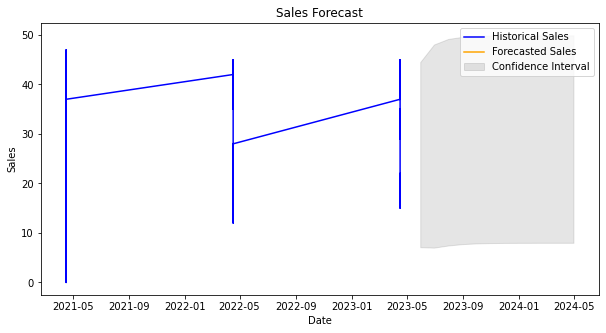

In [0]:
# Forecast for the next 12 months
n_periods = 12
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(start=sales_data_pd.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='M')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecasted Sales'])

conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower CI', 'Upper CI'])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sales_data_pd['Sales'], label='Historical Sales', color='blue')
plt.plot(forecast_df, label='Forecasted Sales', color='orange')
plt.fill_between(conf_int_df.index, conf_int_df['Lower CI'], conf_int_df['Upper CI'], color='k', alpha=0.1, label='Confidence Interval')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual_sales = sales_data_pd['Sales'].values[-n_periods:] 
predicted_sales = forecast
mae = mean_absolute_error(actual_sales, predicted_sales)
mse = mean_squared_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_sales - predicted_sales) / actual_sales)) * 100
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Mean Absolute Error (MAE): 7.48
Mean Absolute Percentage Error (MAPE): 27.99%
Root Mean Squared Error (RMSE): 9.04


In [0]:
!pip install mlflow

     |████▎                           | 3.6 MB 4.8 MB/s eta 0:00:05

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 562 kB 53.0 MB/s 
     |████████████████████████████████| 78 kB 10.7 MB/s 
     |████████████████████████████████| 208 kB 53.1 MB/s 
     |████████████████████████████████| 64 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 44.5 MB/s 
     |████████████████████████████████| 227 kB 56.5 MB/s 
     |████████████████████████████████| 97 kB 10.5 MB/s 
     |████████████████████████████████| 62 kB 2.2 MB/s 
     |████████████████████████████████| 181 kB 55.6 MB/s 
     |████████████████████████████████| 203 kB 51.4 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 80 kB 13.4 MB/s 
     |████████████████████████████████| 149 kB 55.5 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 597 kB 47.5 MB/s 
  Attemptin

2024/10/07 06:38:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-7f109-8da38-29a65-c/tmpc2cryx8j/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/07 06:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/07 06:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-shad-785 at: https://community.cloud.databricks.com/ml/experiments/1147118692185454/runs/b614ffb9ade24d9a82df92a48b9a7afa.
2024/10/07 06:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1147118692185454.


MLflow run completed.


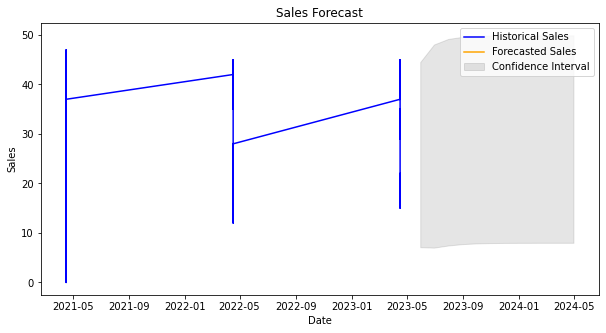

In [0]:
import mlflow
import mlflow.sklearn  

with mlflow.start_run():
    
    mlflow.log_param("seasonal", True)
    mlflow.log_param("seasonality_period", 12)
    
    mlflow.log_text(sarima_model.summary().as_text(), "model_summary.txt")
    
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("RMSE", rmse)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sales_data_pd['Sales'], label='Historical Sales', color='blue')
    plt.plot(forecast_df, label='Forecasted Sales', color='orange')
    plt.fill_between(conf_int_df.index, conf_int_df['Lower CI'], conf_int_df['Upper CI'], color='k', alpha=0.1, label='Confidence Interval')
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    
    plt.savefig("forecast_plot.png")
    
    mlflow.log_artifact("forecast_plot.png")

    mlflow.sklearn.log_model(sarima_model, "SARIMA_Model")

print("MLflow run completed.")


2024/10/07 06:49:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-7f109-8da38-29a65-c/tmp_4vb790e/model, flavor: pmdarima). Fall back to return ['pmdarima==2.0.4']. Set logging level to DEBUG to see the full traceback. 
2024/10/07 06:49:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/07 06:49:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-rook-812 at: https://community.cloud.databricks.com/ml/experiments/1147118692185454/runs/c6fa3a09a389466d8198515e429b2dde.
2024/10/07 06:49:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1147118692185454.
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported in

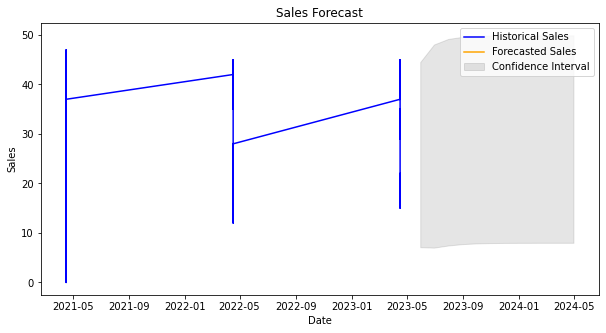

In [0]:
import mlflow
import mlflow.pmdarima

# Start an MLflow run
with mlflow.start_run() as run:  # Capture the 'run' object here
    
    # Log model parameters
    mlflow.log_param("seasonal", True)
    mlflow.log_param("seasonality_period", 12)
    
    # Log model summary
    mlflow.log_text(sarima_model.summary().as_text(), "model_summary.txt")
    
    # Log the metrics (MAE, MAPE, RMSE)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("RMSE", rmse)
    
    # Log the forecast plot as an artifact
    plt.figure(figsize=(10, 5))
    plt.plot(sales_data_pd['Sales'], label='Historical Sales', color='blue')
    plt.plot(forecast_df, label='Forecasted Sales', color='orange')
    plt.fill_between(conf_int_df.index, conf_int_df['Lower CI'], conf_int_df['Upper CI'], color='k', alpha=0.1, label='Confidence Interval')
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.savefig("forecast_plot.png")
    mlflow.log_artifact("forecast_plot.png")
    
    # **Save the SARIMA model**
    mlflow.pmdarima.log_model(sarima_model, artifact_path="model")

# Capture the run ID from the 'run' object
run_id = run.info.run_id
model_uri = f"runs:/{run_id}/model"

# Load the model for inference
loaded_model = mlflow.pmdarima.load_model(model_uri)

# Use the loaded model to make predictions
n_periods = 12
forecast_loaded, conf_int_loaded = loaded_model.predict(n_periods=n_periods, return_conf_int=True)

# Verify that the predictions match
assert (forecast == forecast_loaded).all(), "Forecasts do not match!"